### SPARC Technical question 2B: Happiness 
Applicant name: Johanan Lee Mahendran


#### Overview
My method to figure out a person's happiness is to take a normalised weighted average of the happiness of that person's acquaintances. Every person has a baseline happiness, a degree of extroversion (i.e. how much happiness they exprience by the number of people). 
The people are modeled as cliques in a graph with a mode clique size of 10. An edge between two people in the graph indicates that the two people are acquaintances of each other. Each edge has an associated weight that represent how postive the relationship is.  
Throughout the model, I assume rather optimistically that people generally form positive bonds with each other and that most people enjoy other's company. This should lead to the common sense assumption that if the acquaintances of a person is happy, the person themself would be happy.



### Defining terms and concerns

#### What does it mean to be happy? 
This is such a awkward question in my opinion. One person's happiness can be another person's nightmare. And is there really an absolute objective measure of happiness? 
I generally consider someone happy when they are "content with their current situation", but I somewhat regret making this definition. 
Their "current situation" is an unspecified in time and space. Nobody is happy at all times and in all places. 
My happiness is a score from 0 to 10, where 0 is the least happy and 10 is the most happy.  
To get a sense of the ground truth happiness I set up a survey to figure out people's happiness and the happiness of their acquaintances: https://forms.gle/ZwauygdMycA8EWnJ6


#### What does it mean to be an "acquaintance"?
The question sheet specified that an acquaintance is "someone who interacts frequently with a person".
But what does interact mean here? 
There are many ways two people could interact. They could speak directly to each, they could chat on-line, use sign language, send each other messages on carrier pigeons, nod to each other as they pass by, play a game of chess, share a blunt and so on.   
Some interactions only occur when you have three or more people together: playing an online team game, participating in a race, acting in a play together, playing together as a band, etc. 
For simplicity, I take interact as to mean "meaningfully communicate one-to-one with each other". This might rule out cases like two people bumping into each other, but as with most classficiations they are not strict. 


#### How frequent is frequently?  
Is it daily? Weeky? An unspecified but short period of time? What about people that meet consistently but over long periods? 
I decided to keep the meaning of "recently" vague and instead have my model occur only at a "slice" of time. 
A problem with only considering a "slice of time" is that people in general aren't happy or unhappy all the time. Evaluating the happiness of people in an instant would not indicate if the person is satisfied with their life. 
To give an example, a depressed person might be cheered up by friend every now and then, but they face general unhappiness.

For all intents and purposes, when I say "Person A is acquainted with person B" mean "Person A communicates with person B on an almost daily basis". 

#### What are the external factors?  
This is such a hard question in my opinion. First of all, it's not clear what is an external factor and what is one happiness. 
A person may be misreable even if they have many happy acquaintances (e.g. this person may be bullied by all their acquaintances) or someone may be happy even if they are all alone (e.g. living their dream life in their beach house).
Due to these considerations, I consider three additional factors:
- 1) Whether the interaction between person A and person B is positive (i.e. if person A's happiness increases so does person B's), negative (i.e. if person A's happiness increases, then person B's happiness decreases) or neutral (person A's and person B's happiness do not influence each other.) 
- 2) Each person has an extroversion score. i.e. an innate characteristic of the person which dictates if they are happy depending on the number of acquaintences or not. You can think of this as a person's "sensitivity to number of people they are interacting with" 
- 3) A third factor that acts like a baseline. This can be thought of as all the external factors that does not fall into 1 or 2, lumped together into a single metric.

### Generating the weights
I'm assuming that most interactions with people are positive and so the distribution of the weights has a slight right skew. 
The distribution below was eyeballed and I think finetuning it will allow for a more accurate model. 

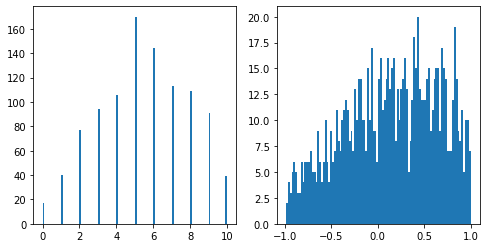

10


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import random

def random_skewed():
    return np.random.choice(np.arange(0, 11), p=[0.02,0.04,0.07,0.11,0.12,0.15,0.14,0.13,0.1,0.08,0.04])

def random_uniform():
    return np.random.uniform(-1,1)

def random_skewed_continuous():
    x = np.random.normal(loc = 0.3, scale = 0.8)
    while x < -1 or x > 1:
        x = np.random.normal(loc = 0.3, scale = 0.8)
    return x

Y = [] 
Z = []
for _ in range(1000):
    Y.append(random_skewed())
    Z.append((random_skewed_continuous()))
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].hist(Y, bins=100)
axs[1].hist(Z, bins=100)
plt.show()
print(max(Y))

### How do I model the people and interactions?
I model my community of $N$ people using an directed graph. The nodes are the people and if an edge exists between two people are acquainted. 
There will be no edges from the person to themself. The edges are directed since Person A migh have a positive interaction with Person B but Person B might have a negative one. But in all cases, I take communication to be a two-way process and so all edges have an antiparallel edge-- if person A interacts with person B, then person B interacts with person A.  

I would also give each person an extroversion score. The extroversion score is selected from a uniform distribution. Positive values indicate more extroversion and negative values indicate more introversion. 
In addition to that, each edge has an associated weight. This is to indicate whether the interaction is positive or negative.
And finally, the baseline happiness, which is the happiness a person experiences when they have no interactions.
NB: Happiness is calculated on the scale of 0 to 10 inclusive.  

The weight of the edge is a value between -0.5 and 0.5, slightly skewed to favour positive interactions.
  
My happiness formula is the following : 
$$ \text{happiness(A)} =   \left( \frac{1}{N+1} \right) \left( \left( \sum_{p \in \text{ acquintances of A}} {rescale(\text{p.happiness} \times weight(A,p))} \right) + {rescale(N \times \text{A.extroversion})} \right) $$

Where $N$ is the number of aquaintances of A, weight(A,p) is the weight of the relationship between A and p, and $rescale$ is the function defined by $rescale(x) = \tanh(x) \times 5+5$

The intuition behind $rescale$ was that I needed a function that would normalize the results if it ever gets larger than 10 or smaller than 0. One such function was $tanh$, however since $tanh$ only has a range between -1 and 1, I had to multiply the $tanh$ with 5 and then adding 5 to get the value between the range 0 to 10. 

Two issues that can arise is that 
A problem that I realised is that I can end up with an infinite loop if person A's happiness depends on person B's happiness, but also person B's happiness depends on person A's happiness. 
A way to resolve this is to start every person with their baseline happiness and then iteratively calculate the happiness.  
I am assuming that the happiness tends towards a fixed value over time and that by using a high number of iterations, I can get really close to the "stable happiness".

In [4]:
def rescale(x):
    return np.tanh(x)*5 + 5


class Person:
    def __init__(self, extroversion, base_line):
        self.extroversion = extroversion
        self.base_line = base_line
        self.acquaintences = {}
        self.happiness = base_line
    
    def make_acquaintence(self, other, weight = None):
        #creates a directed edge from self person to other person with weight
        if weight is None:
            weight = random_skewed_continuous()
        self.acquaintences[other] = weight

class Graph():
    def __init__(self, persons = []):
        self.persons = persons
        
    def size(self):
        return len(self.persons)  

    def incidence_graph(self):
        n = len(self.persons)
        graph = np.zeros((n,n))
        for i in range(n):
            person = self.persons[i]
            acquaintences = person.acquaintences
            for j in range(n):
                acq = self.persons[j]
                if acq in acquaintences:
                    graph[i,j] = person.acquaintences[acq]
        return graph    

    def calculate_happiness(self, i = 2000):
        for n in range(i):
            people_list = random.sample(self.persons, k=len(self.persons))
            for p in people_list:
                acq = [rescale(x.happiness*p.acquaintences[x]) for x in p.acquaintences]
                extro = rescale(len(acq) * p.extroversion)
                acq.append(extro)
                p.happiness = sum(acq)/len(acq)

    def combine_graphs(self, other):
        return Graph(self.persons + other.persons)

    def draw_graph(self):
        graph = nx.convert_matrix.from_numpy_array(self.incidence_graph())
        nx.draw(graph)

## How does the graph look like?  
I'll be assuming that the people are connected to each other in a "small-world graph".  
That is to say, people tend to form cliques -- if person A is acquatinted with person B, and person A is acquainted with person C, then it is likely that person B is acquainted with person C.  
Furthermore, not only do people form cliques but these cliques are connected by only a few individuals. 

One way this is implemented is to form a clique graph where every person is an acquaintance with each other. These cliques are then connected to each other by having a random person in each clique be acquainted to each other.  

In [5]:
class Clique(Graph):
    def __init__(self, n, persons = None):
        if persons == None:
            self.persons = []
            for _ in range(n):
                extroversion = random_uniform()
                base_line = random_skewed()
                person = Person(extroversion, base_line)
                for acquaintance in self.persons:
                    acquaintance.make_acquaintence(person)
                    person.make_acquaintence(acquaintance)
                self.persons.append(person)
        else:
            self.persons = persons

    def combine_cliques(self, other):
        if isinstance(other, Clique): 
            person = np.random.choice(self.persons)
            acquaintance = np.random.choice(other.persons)
            person.make_acquaintence(acquaintance)
            acquaintance.make_acquaintence(person)
            return Clique(0,persons = self.persons + other.persons)


The community of n people are split randomly into cliques of various sizes. The probabilities of chosing a clique of a size is decided ad hoc and hard coded. 

In [26]:

def generate_cliques(n):
    total = 0
    clq = []
    p = [0.01,0.01,0.01,0.02,0.06,0.09,0.1,0.18,0.2,0.11,0.06,0.04,0.03,0.02,0.02,0.01,0.01,0.01,0.01]
    while total < n:
        x = np.random.choice(np.arange(1, 20), p = p)
        clq.append(x)
        total += x
    if total > n:
        clq[-1] = clq[-1]-(total-n)
    return clq

def create_community(cliques = [5,5,3]):
    graph = Clique(cliques[0])
    for n in cliques[1:]:
        graph = graph.combine_cliques(Clique(n))
    return graph

Finally displaying and comparing against the ground truth. 
The simulated happiness is done over 500 people. 

Cliques:  [7, 4, 19, 9, 7, 10, 15, 7, 6, 8, 9, 10, 8, 15, 11, 16, 9, 11, 8, 7, 9, 10, 9, 9, 9, 9, 7, 9, 10, 17, 3, 7, 3, 4, 10, 8, 10, 11, 11, 9, 7, 7, 11, 11, 12, 8, 7, 8, 8, 11, 8, 4, 4, 8, 7, 4, 5]
Average ground truth happiness:  4.882352941176471
Average simulated happiness:  4.5181105644923045


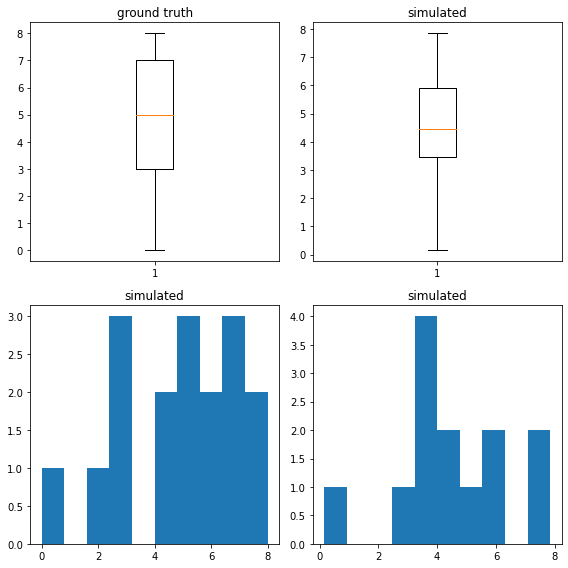

In [27]:

ground_truth = [0,2,3,3,3,4,4,5,5,5,6,6,7,7,7,8,8]

def avg(l):
    return sum(l)/len(l)

def simulation(n):
    clq = generate_cliques(n)
    print("Cliques: ", clq)
    return create_community()

g = simulation(500)   
g.calculate_happiness()

H = [p.happiness for p in g.persons]
print("Average ground truth happiness: ", avg(ground_truth))
print("Average simulated happiness: ", avg(H))

fig, axs = plt.subplots(2, 2, figsize = (8,8))
axs[0,0].boxplot(ground_truth)
axs[0,0].set_title("ground truth")
axs[0,1].boxplot(H)
axs[0,1].set_title("simulated")
axs[1,0].hist(ground_truth)
axs[1,0].set_title("simulated")
axs[1,1].hist(H)
axs[1,1].set_title("simulated")

plt.tight_layout()
plt.show()

Bibliography and References:  
J. H. Fowler, N. A. Christakis, (2008) Dynamic spread of happiness in a large social network: longitudinal analysis over 20 years in the Framingham Heart Study, Downloaded from http://www.bmj.com/ on 10 April 2021.
